# Deteksi Double Counting dengan Isolation Forest

Notebook ini menerapkan pendekatan dua tahap:
1. Mengidentifikasi data klaim yang diduga double counting menggunakan Isolation Forest.
2. Menghitung estimasi cadangan klaim dengan metode Chain Ladder dan Bornhuetter‑Ferguson pada data mentah dan data yang telah dibersihkan dari anomali.

Dataset: `claims_company_style_with_reported_year.csv`


In [4]:
!pip install chainladder pandas scikit-learn matplotlib seaborn --quiet

In [5]:
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt
import seaborn as sns


In [6]:
url = 'https://raw.githubusercontent.com/EvansKizito/Datathon/refs/heads/main/claims_company_style_with_reported_year.csv'
df = pd.read_csv(url)
df.head()

,policy_id,line_of_business,exposure_premium,accident_year,development_year,incremental_paid,cumulative_paid,incremental_incurred,cumulative_incurred,reported_year
0,P0001,Health,12828.63,2005,1,5162.07,5162.07,3485.56,3485.56,2005
1,P0001,Health,12828.63,2005,2,22425.50,27587.57,8571.92,12057.47,2006
2,P0001,Health,12828.63,2005,3,1211.47,28799.05,6266.80,18324.28,2007
3,P0001,Health,12828.63,2005,4,3146.17,31945.22,9988.67,28312.95,2008
4,P0001,Health,12828.63,2005,5,2871.04,34816.26,5075.54,33388.48,2009


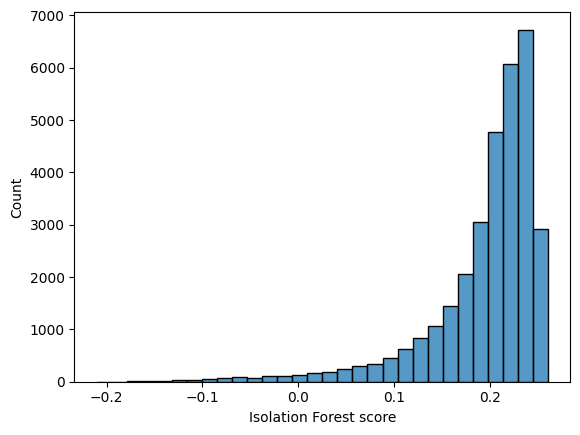

Jumlah anomali: 640


In [7]:
# Fitur untuk deteksi anomali
a_features = df[['incremental_paid','incremental_incurred','cumulative_paid','cumulative_incurred']]
iso = IsolationForest(contamination=0.02, random_state=42)
df['anomaly'] = iso.fit_predict(a_features)

# Visualisasi skor anomali
sns.histplot(iso.decision_function(a_features), bins=30)
plt.xlabel('Isolation Forest score')
plt.show()

print('Jumlah anomali:', (df['anomaly']==-1).sum())


In [8]:
clean_df = df[df['anomaly'] != -1].copy()
print('Data bersih:', clean_df.shape)


Data bersih: (31360, 11)


In [9]:
def build_triangle(data):
    tri = data.pivot_table(index='accident_year', columns='development_year', values='cumulative_paid', aggfunc='sum').sort_index()
    return tri

def chain_ladder(triangle):
    dev_periods = triangle.columns.tolist()
    n = len(dev_periods)
    factors = []
    for j in range(n-1):
        numer = triangle.loc[:, dev_periods[j+1]].iloc[:-j-1].sum()
        denom = triangle.loc[:, dev_periods[j]].iloc[:-j-1].sum()
        factors.append(numer/denom)
    factors.append(1.0)
    ultimate = {}
    for i, row in triangle.iterrows():
        last_dev = row.last_valid_index()
        idx = dev_periods.index(last_dev)
        factor_prod = np.prod(factors[idx:])
        ultimate[i] = row[last_dev] * factor_prod
    return pd.Series(ultimate), factors

def bornhuetter_ferguson(triangle, exposures, factors):
    dev_periods = triangle.columns.tolist()
    lr = triangle.iloc[:,-1].sum() / exposures.sum()
    ultimates = {}
    cum_factors = np.cumprod(factors)
    for i, row in triangle.iterrows():
        last_dev = row.last_valid_index()
        idx = dev_periods.index(last_dev)
        percent_reported = 1.0/cum_factors[idx]
        expected = exposures.loc[i] * lr
        ultimates[i] = row[last_dev] + expected*(1-percent_reported)
    return pd.Series(ultimates)


In [10]:
triangle_raw = build_triangle(df)
triangle_clean = build_triangle(clean_df)

exposure = df.groupby('accident_year')['exposure_premium'].sum()

cl_raw, factors = chain_ladder(triangle_raw)
cl_clean, _ = chain_ladder(triangle_clean)

bf_raw = bornhuetter_ferguson(triangle_raw, exposure, factors)
bf_clean = bornhuetter_ferguson(triangle_clean, exposure, factors)

result = pd.DataFrame({
    'CL_raw': cl_raw,
    'CL_clean': cl_clean,
    'BF_raw': bf_raw,
    'BF_clean': bf_clean
})
result

,CL_raw,CL_clean,BF_raw,BF_clean
2005,18699543.48,16682971.21,3.543469e+07,3.183528e+07
2006,18112789.69,16765727.90,3.484794e+07,3.191803e+07
2007,19336344.41,16276821.59,3.607149e+07,3.142913e+07
2008,18598795.64,16189575.32,3.533395e+07,3.134188e+07
2009,18411043.44,16831561.58,3.514619e+07,3.198387e+07
2010,18748868.79,16925591.75,3.548402e+07,3.207790e+07
2011,17927516.03,17047733.04,3.466267e+07,3.220004e+07
2012,18656050.33,17011917.95,3.539120e+07,3.216422e+07
2013,18249432.66,17231405.81,3.498458e+07,3.238371e+07
2014,18791073.80,16683710.27,3.552622e+07,3.183602e+07


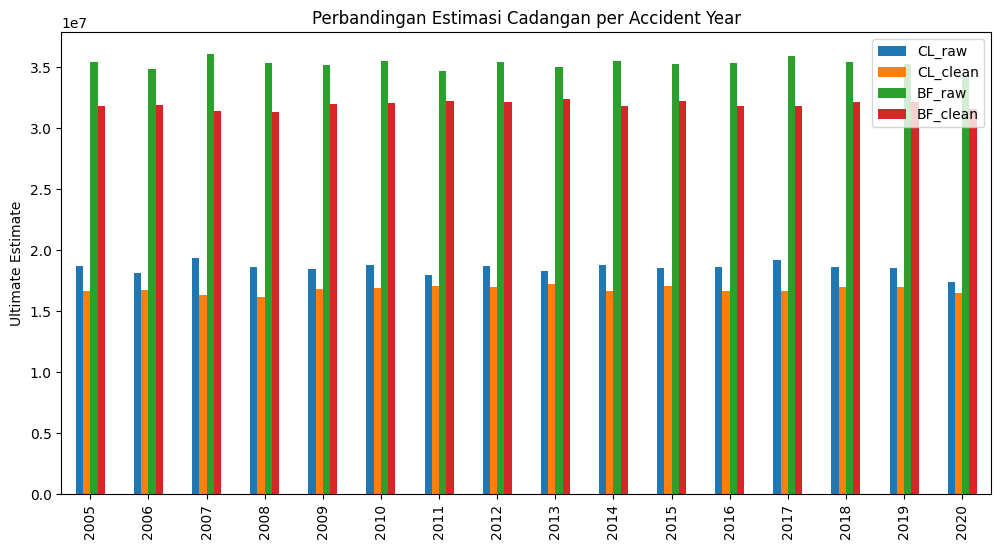

In [11]:
result.plot(kind='bar', figsize=(12,6))
plt.ylabel('Ultimate Estimate')
plt.title('Perbandingan Estimasi Cadangan per Accident Year')
plt.show()
